# Confidence interval plotting for the GSD of my sediment baskets
based off the approximate solution for binned data section of Eaton (2019) and the WolmanCI function from the GSDtools R package 

In [1]:
# importing all our libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import binom

Import the data (in this case we will be doing the LISST data)

In [2]:
# directory where the CSV files are located
folder_path = "LISST"

# list all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# loop through each CSV file and read it into a DataFrame and create variables
for csv_file in csv_files:
    file_name = os.path.splitext(csv_file)[0]  # Get the file name without the extension
    file_path = os.path.join(folder_path, csv_file)
    # create a variable with the file name and store the DataFrame
    exec(f"{file_name} = pd.read_csv(file_path)")

`WolmanCI` is a function that uses cumulative frequency distribution data for Wolman or grid-by-number samples of bed surface texture to estimate the value of user-specified percentiles. In this case I will be using it for my fine grain size distribution, not necessarily for bed grains

The function also uses the binomial distribution to estimate the confidence intervals corresponding to a user-specified confidence level, based on the number of grain size measurements that were used to construct the cumulative frequency distribution.

The function returns a data frame listing the estimate of each percentile, the upper limit, and the lower limit.

In [3]:
def WolmanCI(cfd, n, P=np.arange(5, 100, 5), equaltail=True, alpha=0.05):
    # convert percentiles to probabilities
    probs = P / 100

    p_upper = np.zeros(len(probs))
    p_lower = np.zeros(len(probs))

    if equaltail:
        for i, prob in enumerate(probs):
            p_lower[i], p_upper[i] = binom.interval(1 - alpha, n, prob)
    else:
        p_lower[i], p_upper[i] = binom.interval(alpha, n, prob)

    p_lower = p_lower / n
    p_upper = p_upper / n

    # estimate percentiles
    phi = np.log2(cfd.iloc[:, 0])
    X = cfd.iloc[:, 1]
    estimate = 2 ** np.interp(probs, X, phi)
    upper = 2 ** np.interp(p_upper, X, phi)
    lower = 2 ** np.interp(p_lower, X, phi)

    results = pd.DataFrame({
        'percentile': P,
        'estimate': estimate,
        'lower': lower,
        'upper': upper
    })

    return results

**Input Variables:**

- `cfd`: cfd is a data frame providing a list grain sizes in the first variable and the corresponding cumulative proportion finer in the second. The grain sizes should be recorded in mm, and the proportion finer in [0,1].

- `n`: n is the total number of observations upon which the cumulative frequency distribution cfd is based

- `P`: A numpy array of percentiles. By default, it's an array from 5 to 95 with a step of 5.

- `equaltail`: A boolean that determines whether the confidence interval is equal-tailed. If `True`, the alpha level is divided equally between the two tails of the distribution. If `False`, the entire alpha level is assigned to one tail. The default is `True`.

- `alpha`: A float that represents the significance level for the confidence interval. The default is 0.05, which corresponds to a 95% confidence interval.

**Output Variable:**

- `results`: A pandas DataFrame that contains the estimated percentiles and their corresponding lower and upper bounds of the confidence interval. The DataFrame has the following columns:

  - `percentile`: The percentiles specified in the input `P`.
  
  - `estimate`: The estimated values of the percentiles.
  
  - `lower`: The lower bounds of the confidence intervals for the estimated percentiles.
  
  - `upper`: The upper bounds of the confidence intervals for the estimated percentiles.

In [4]:
# Test
df = LISST_cumconc.iloc[:, :2].copy() # note: size is in microns

# converting the percent finer to [0, 1]
df.iloc[:, 1] = df.iloc[:, 1] / 100

In [15]:
# calculate the confidence intervals
df = df.sort_values(by=df.columns[1])
results = WolmanCI(df, 44, P=np.arange(5, 100, 5), equaltail=True, alpha=0.2)

In [16]:
results

,percentile,estimate,lower,upper
0,5,8.013567,0.370000,16.304773
1,10,17.998693,7.110432,29.019509
2,15,27.417328,16.304773,40.876079
3,20,36.277017,20.567415,48.388496
4,25,44.762070,29.019509,59.479560
5,30,53.000187,37.091238,67.118509
6,35,61.003432,44.762070,75.281832
7,40,69.492018,52.202126,88.178698
8,45,78.523431,63.341441,98.085441
9,50,88.178698,71.120806,109.364126


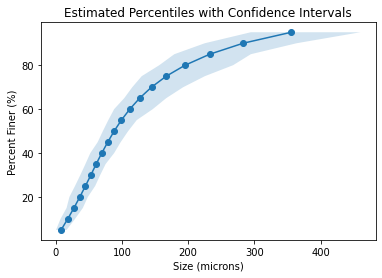

In [17]:
# Plot the estimated percentiles
plt.plot(results['estimate'], results['percentile'], 'o-')
plt.fill_betweenx(results['percentile'], results['lower'], results['upper'], alpha=0.2)

plt.ylabel('Percent Finer (%)')
plt.xlabel('Size (microns)')
plt.title('Estimated Percentiles with Confidence Intervals')

plt.show()

In [18]:
results = {}
for column in LISST_cumconc.columns[1:]:  # Skip the first column (sizes)
    cfd = LISST_cumconc[[LISST_cumconc.columns[0], column]]
    results[column] = WolmanCI(cfd, len(LISST_cumconc))

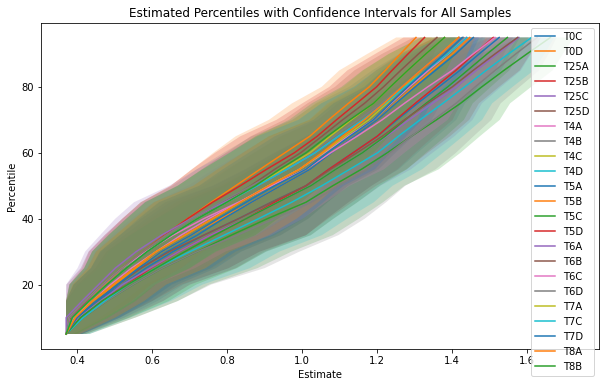

In [19]:
plt.figure(figsize=(10, 6))

for sample, result in results.items():
    plt.plot(result['estimate'], result['percentile'], label=sample)
    plt.fill_betweenx(result['percentile'], result['lower'], result['upper'], alpha=0.2)

plt.ylabel('Percentile')
plt.xlabel('Estimate')
plt.title('Estimated Percentiles with Confidence Intervals for All Samples')
plt.legend()

plt.show()

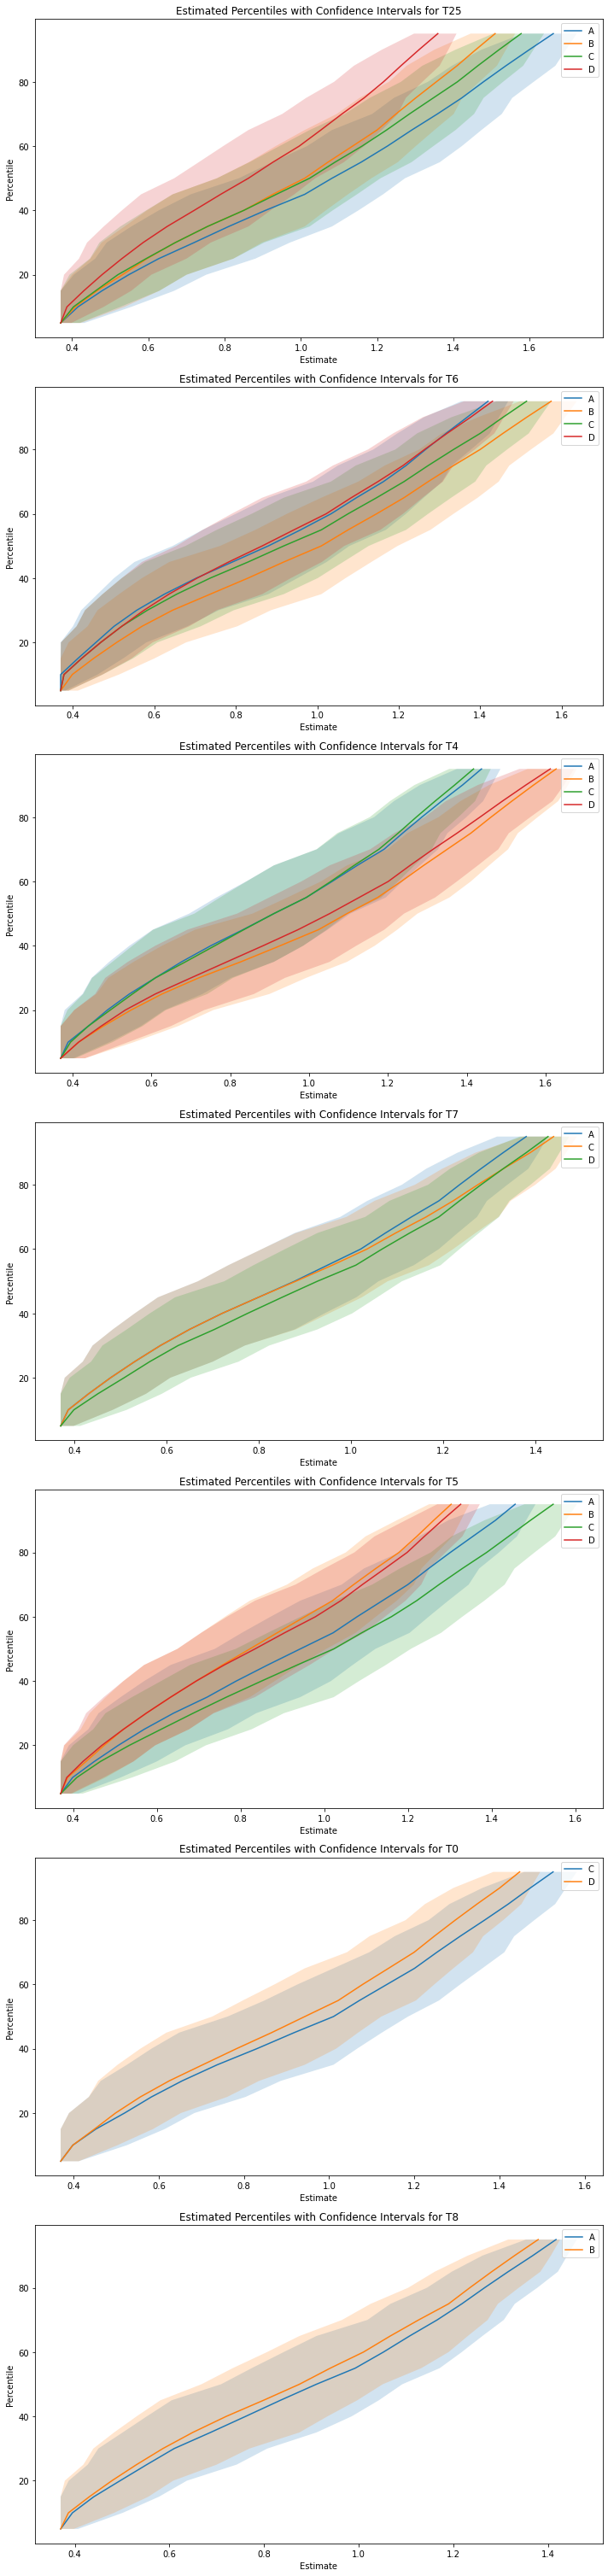

In [20]:
sample_groups = ['T25', 'T8', 'T0', 'T4', 'T5', 'T6', 'T7']
subsamples = ['A', 'B', 'C', 'D']

fig, axs = plt.subplots(len(sample_groups), figsize=(10, 6 * len(sample_groups)))

for ax, group in zip(axs, sample_groups):
    for subsample in subsamples:
        sample = group + subsample
        if sample in results:
            result = results[sample]
            ax.plot(result['estimate'], result['percentile'], label=subsample)
            ax.fill_betweenx(result['percentile'], result['lower'], result['upper'], alpha=0.1)

    ax.set_ylabel('Percent Finer (%)')
    ax.set_xlabel('Size (microns)')
    ax.set_title(f'GSD Confidence Intervals for {group}')
    ax.legend()

plt.tight_layout()
plt.show()